# Introductino to SINDy

Sparse Identification of Nonlinear Dynamics (SINDy) is a data driven methods of discovering governing equation from a dynamical time series data. It was introduced by Brunton et al. in 2016 to identify sparse and interpretable models from the data. We assume that the data dynamics are expressed as linear combination of a library of candidate functions and use sparse regression to select only relevant terms.  

$$\bold{\dot{x}} = \bold{\Theta}(\bold{x}) \bold{\xi}$$
where $\mathbf{\Theta}(\mathbf{x})$ is a matrix of candidate functions evaluated on the state $\mathbf{x}$, and $\boldsymbol{\xi}$ is a sparse coefficient vector found via optimization.

## Step 1: Generate Synthetic Data
We simulate the PDE using finite differences on a 1D domain $[0, 2]$ with 1001 spatial points and 2000 time steps ($\Delta t = 0.001$).
For the heat equation (linear diffusion):

Initial condition: Gaussian bump $u(x,0) = e^{-(x - 1)^2}$

For Burgers' equation (nonlinear advection-diffusion):

Initial condition: Sine wave $u(x,0) = \sin(2\pi x / 2)$

Code for data generation (heat equation example):
The heat (diffusion) equation: $u_t = 0.1 u_{xx}$
$$(u_{t+1,x}-u_{t,x})/dt = 0.1(u_{t,x}-2u_{t,x-1}+u_{t,x-2})/(dx)^2$$

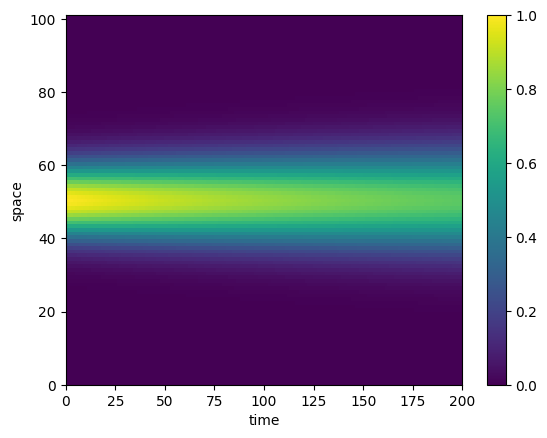

In [8]:
import numpy as np

# Parameters
L = 10  # Domain length
nx = 101  # Spatial points
dx = L / (nx - 1)
nt = 200  # Time points
dt = 0.01  # Time step
alpha = 0.1  # Diffusion coefficient

# Initial condition
x = np.linspace(0, L, nx)
u0 = np.exp(- (x - L/2)**2 )

# Simulate
u = np.zeros((nt, nx))
u[0] = u0
for n in range(1, nt):
    u[n, 1:-1] = u[n-1, 1:-1] + alpha * dt / dx**2 * (u[n-1, 2:] - 2*u[n-1, 1:-1] + u[n-1, :-2])

u = u.T  # Shape: (nx, nt)

import matplotlib.pyplot as plt 
a = plt.pcolor(u)
plt.colorbar(a)
plt.xlabel("time")
plt.ylabel("space")
plt.show()

## Computing derivatives 

In [9]:
u_t = np.gradient(u,dt,axis=1) # ∂u/∂t
u_x = np.gradient(u,dx,axis=0) # ∂u/∂x
u_xx = np.gradient(u_x,dx,axis=0) # ∂²u/∂x²

# FOcusing on interior points to reduce boundary errors .
ix = slice(2,-2) # Skip edge in space
it = slice(1,-1) # Skip edge in time 
Ut = u_t[ix,it].flatten()
Ux = u_x[ix,it].flatten()
Uxx = u_xx[ix,it].flatten()

U = u[ix,it].flatten() # State 

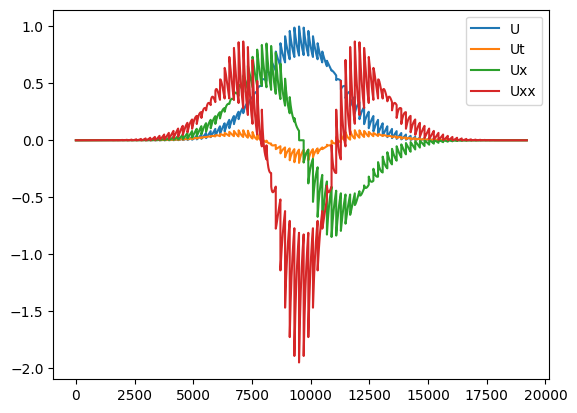

In [11]:
plt.plot(U, label="U")
plt.plot(Ut, label="Ut")
plt.plot(Ux, label="Ux")
plt.plot(Uxx,label="Uxx")
plt.legend()
plt.show()

## Build the library matrix $\Theta$
Selected candidate terms : $1, u, u², u_x, u u_x, u² u_x, u_xx, u u_xx, u² u_xx$

In [12]:
ones = np.ones_like(U)
Theta = np.vstack([ones, U, U**2, Ux, U * Ux, U**2 * Ux, Uxx, U * Uxx, U**2 * Uxx]).T
# Shape: (num_points, num_terms)


## Step 4: Sparse Regression with STLSQ
Solve $\mathbf{U_t} = \mathbf{\Theta} \boldsymbol{\xi}$ using sequential thresholded least squares:

- Start with ordinary least squares.
- Threshold small coefficients to zero.
- Refit on remaining terms.
- Repeat for a few iterations.

In [14]:
from scipy.linalg import lstsq

def stlsq(Theta, Ut, threshold=0.05, iterations=20):
    xi = lstsq(Theta, Ut)[0]
    for _ in range(iterations):
        small_inds = np.abs(xi) < threshold
        xi[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        xi[big_inds] = lstsq(Theta[:, big_inds], Ut)[0]
    return xi

## Apply STLSQ and print non-zero coefficients.
For the heat equation (using a linear-restricted library for better sparsity):
This recovers $u_t \approx 0.1 u_{xx}$, matching the true PDE.

In [16]:
Theta_linear = np.vstack([ones,U,Ux,Uxx]).T 
xi = stlsq(Theta_linear,Ut,threshold=0.005,iterations=100)
# Features: ['1', 'u', 'u_x', 'u_xx']
# Recovered: u_xx: 0.1012 (close to 0.1; slight error from numerical differentiation)

In [18]:
print(xi.shape)
print(xi)

(4,)
[0.         0.         0.         0.10118168]


example: $u_t = 0.1 \cdot t \cdot x \cdot u_{xx}$ on the domain $x \in [0, 1]$, $t \in [0, 2]$ to keep values manageable.  
 When run, this recovers approximately $u_t \approx 0.1 \cdot t \cdot x \cdot u_{xx}$, with minor numerical discrepancies (e.g., coefficient ~0.1004).

Step 1: Generate Synthetic Data
Simulate the PDE using explicit finite differences. To ensure stability (since the effective diffusion $a = 0.1 t x$ reaches up to ~0.2), we use a smaller $\Delta t = 5 \times 10^{-4}$ and $n_t = 4000$ to reach $t=2$. Domain: $x \in [0,1]$, $n_x = 51$.

In [1]:
import numpy as np

# Parameters
L = 1.0  # Domain length [0,1]
nx = 51  # Spatial points
dx = L / (nx - 1)
nt = 4000  # Time steps for t_max=2
dt = 0.0005  # Time step for stability
alpha = 0.1  # Base coefficient

# Spatial and time grids
x = np.linspace(0, L, nx)
t_grid = np.linspace(0, dt*(nt-1), nt)

# Initial condition
u0 = np.exp(- (x - L/2)**2 / 0.05 )

# Simulate u_t = alpha * t * x * u_xx
u = np.zeros((nt, nx))
u[0] = u0
for n in range(1, nt):
    t = (n-1) * dt  # t at previous step
    diff = np.zeros(nx-2)
    for i in range(1, nx-1):
        a = alpha * t * x[i]
        diff[i-1] = a / dx**2 * (u[n-1, i+1] - 2*u[n-1, i] + u[n-1, i-1])
    u[n, 1:-1] = u[n-1, 1:-1] + dt * diff

u = u.T  # Shape: (nx, nt)

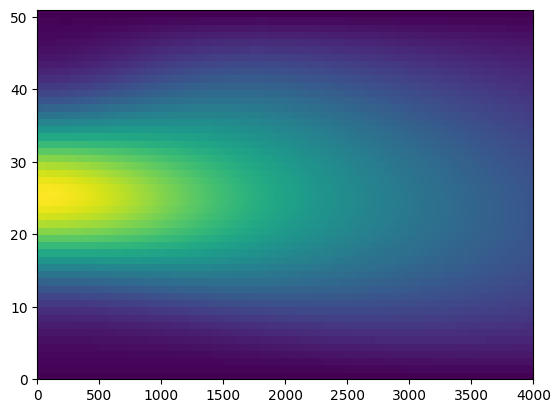

In [3]:
from matplotlib import pyplot as plt 
plt.pcolor(u)
plt.show()

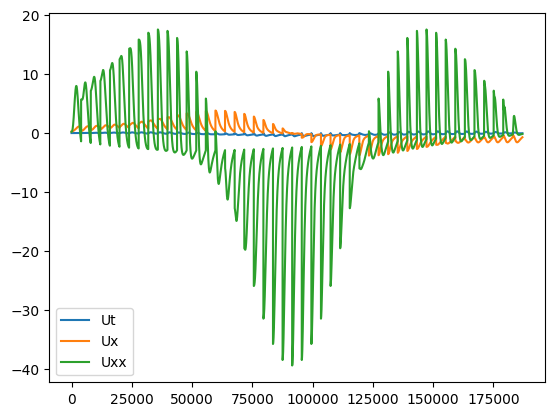

In [7]:
# Derivatives
u_t = np.gradient(u, dt, axis=1)  # ∂u/∂t
u_x = np.gradient(u, dx, axis=0)  # ∂u/∂x
u_xx = np.gradient(u_x, dx, axis=0)  # ∂²u/∂x²

# Interior slices
ix = slice(2, -2)  # Space
it = slice(10, -10)  # Time (skip edges for stability)

# Flatten
Ut = u_t[ix, it].flatten()
Ux = u_x[ix, it].flatten()
Uxx = u_xx[ix, it].flatten()
U = u[ix, it].flatten()

# Create X and T meshes flattened
X, T = np.meshgrid(x[ix], t_grid[it], indexing='ij')
X_flat = X.flatten()
T_flat = T.flatten()
plt.plot(Ut,label="Ut")
plt.plot(Ux,label="Ux") 
plt.plot(Uxx,label="Uxx")
plt.legend()
plt.show()

In [8]:
ones = np.ones_like(U)
# Terms: base * (1, x, t, x t)
terms = [
    ones, U, U**2,  # constants and powers
    Ux, U * Ux,  # u_x terms
    Uxx, U * Uxx,  # u_xx terms
    X_flat * ones, X_flat * U, X_flat * U**2, X_flat * Ux, X_flat * U * Ux, X_flat * Uxx, X_flat * U * Uxx,  # x *
    T_flat * ones, T_flat * U, T_flat * U**2, T_flat * Ux, T_flat * U * Ux, T_flat * Uxx, T_flat * U * Uxx,  # t *
    X_flat * T_flat * ones, X_flat * T_flat * U, X_flat * T_flat * U**2, X_flat * T_flat * Ux, X_flat * T_flat * U * Ux, X_flat * T_flat * Uxx, X_flat * T_flat * U * Uxx  # x t *
]

Theta = np.vstack(terms).T  # Shape: (num_points, num_terms)

# Corresponding feature names (for interpretation)
feature_names = [
    '1', 'u', 'u^2',
    'u_x', 'u u_x',
    'u_xx', 'u u_xx',
    'x', 'x u', 'x u^2', 'x u_x', 'x u u_x', 'x u_xx', 'x u u_xx',
    't', 't u', 't u^2', 't u_x', 't u u_x', 't u_xx', 't u u_xx',
    'x t', 'x t u', 'x t u^2', 'x t u_x', 'x t u u_x', 'x t u_xx', 'x t u u_xx'
]

from scipy.linalg import lstsq

def stlsq(Theta, Ut, threshold=0.01, iterations=20):
    xi = lstsq(Theta, Ut)[0]
    for _ in range(iterations):
        small_inds = np.abs(xi) < threshold
        xi[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        xi[big_inds] = lstsq(Theta[:, big_inds], Ut)[0]
    return xi

xi = stlsq(Theta, Ut, threshold=0.01, iterations=20)

In [9]:
print("Recovered coefficients:")
for i, coeff in enumerate(xi):
    if abs(coeff) > 1e-5:
        print(f"{feature_names[i]}: {coeff:.4f}")

Recovered coefficients:
x t u_xx: 0.1004


When the PDE is black-box but assumed to follow the form $u_t = f(x) u_{xx}$ (where $f(x)$ is unknown and potentially non-constant), we can recover $f(x)$ from spatiotemporal data without full SINDy. Since the structure is fixed except for $f(x)$, a direct approach is to estimate $f(x)$ at each spatial point $x_i$ independently using the time-series data at that point.
Conceptual Overview

At each fixed $x_i$, the equation simplifies to $u_t(t) = f(x_i) u_{xx}(t)$ for all $t$.
This is a linear regression problem: find scalar $f(x_i)$ that best fits the data pairs $(u_{xx}(t), u_t(t))$.
Solve via least squares: $f(x_i) = \frac{\sum_t u_t(t) u_{xx}(t)}{\sum_t u_{xx}(t)^2}$ (assuming $\sum u_{xx}^2 > 0$; skip if low signal to avoid division by near-zero).
This is robust to noise and numerical errors in derivatives, as it averages over many time points.
If $f(x)$ is constant (e.g., heat equation with $f(x) = 0.1$), all recovered values will be approximately equal.
Post-processing: Plot or fit a function (e.g., polynomial) to the $(x_i, f(x_i))$ points to get an analytic form.
Advantages over full SINDy: Simpler, no need for large library; directly gives $f(x)$ without assuming its basis. If you suspect other terms (e.g., advection), use SINDy instead.  

Simulate the PDE with explicit finite differences (vectorized for efficiency).
For constant $f(x) = 0.1$:

Recovered: ~0.1001 at most points (small error from numerics).

For non-constant $f(x) = 0.1 + 0.2 x$:

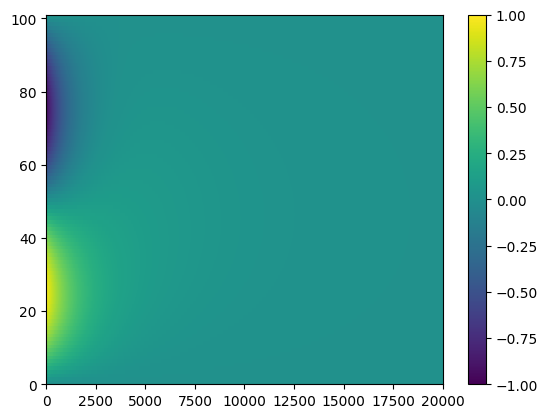

In [10]:
import numpy as np

# Parameters
L = 1.0  # Domain
nx = 101  # Spatial points
dx = L / (nx - 1)
nt = 20000  # Time steps (for t_max ≈ 2)
dt = 1e-4  # Small for accuracy/stability
x = np.linspace(0, L, nx)
t_grid = np.linspace(0, dt * (nt - 1), nt)

# Initial condition (sine for good spatial coverage)
u0 = np.sin(2 * np.pi * x / L)

# Choose f(x): constant or non-constant
# f = 0.1 * np.ones(nx)  # Constant (heat equation)
f = 0.1 + 0.2 * x  # Non-constant example

# Simulate
u = np.zeros((nt, nx))
u[0] = u0
for n in range(1, nt):
    u[n, 1:-1] = u[n-1, 1:-1] + dt * f[1:-1] / dx**2 * (u[n-1, 2:] - 2 * u[n-1, 1:-1] + u[n-1, :-2])

u = u.T  # (nx, nt)
plt.pcolor(u)
plt.colorbar()
plt.show()

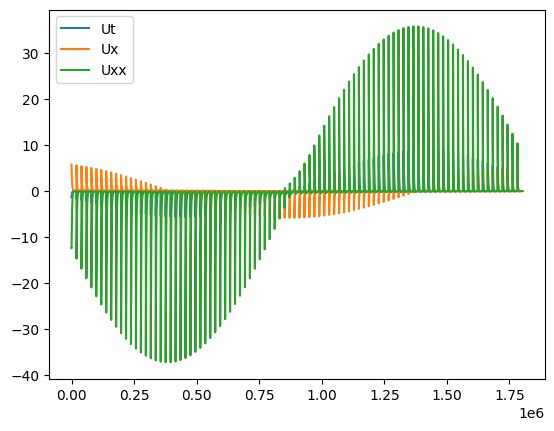

In [11]:
u_t = np.gradient(u, dt, axis=1)  # ∂u/∂t
u_x = np.gradient(u, dx, axis=0)  # ∂u/∂x (not needed, but computed for completeness)
u_xx = np.gradient(u_x, dx, axis=0)  # ∂²u/∂x²

# Interior slices (avoid boundaries and transients)
ix = slice(5, -5)
it = slice(100, -100)

# Flatten
Ut = u_t[ix, it].flatten()
Ux = u_x[ix, it].flatten()
Uxx = u_xx[ix, it].flatten()
U = u[ix, it].flatten()

# Create X and T meshes flattened
X, T = np.meshgrid(x[ix], t_grid[it], indexing='ij')
X_flat = X.flatten()
T_flat = T.flatten()
plt.plot(Ut,label="Ut")
plt.plot(Ux,label="Ux") 
plt.plot(Uxx,label="Uxx")
plt.legend()
plt.show()

In [12]:
recovered_f = np.zeros(nx) * np.nan  # To store results

for i in range(ix.start, ix.stop):
    Ut_i = u_t[i, it]
    Uxx_i = u_xx[i, it]
    sum_uxx2 = np.dot(Uxx_i, Uxx_i)
    if sum_uxx2 > 1e-10:  # Avoid low-signal points
        recovered_f[i] = np.dot(Ut_i, Uxx_i) / sum_uxx2

# Print samples or plot
report_x = [0.1, 0.3, 0.5, 0.7, 0.9]
for xv in report_x:
    idx = np.argmin(np.abs(x - xv))
    if not np.isnan(recovered_f[idx]):
        print(f"x = {xv:.1f}, recovered f(x) = {recovered_f[idx]:.4f}, true = {f[idx]:.4f}")
    else:
        print(f"x = {xv:.1f}, skipped (low signal)")

x = 0.1, skipped (low signal)
x = 0.3, skipped (low signal)
x = 0.5, skipped (low signal)
x = 0.7, skipped (low signal)
x = 0.9, skipped (low signal)


In [13]:
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a + b * x

valid_idx = ~np.isnan(recovered_f)
popt, _ = curve_fit(linear_func, x[valid_idx], recovered_f[valid_idx])
print(f"Fitted: f(x) ≈ {popt[0]:.4f} + {popt[1]:.4f} x")

ValueError: `ydata` must not be empty!